# EMPOWER clone

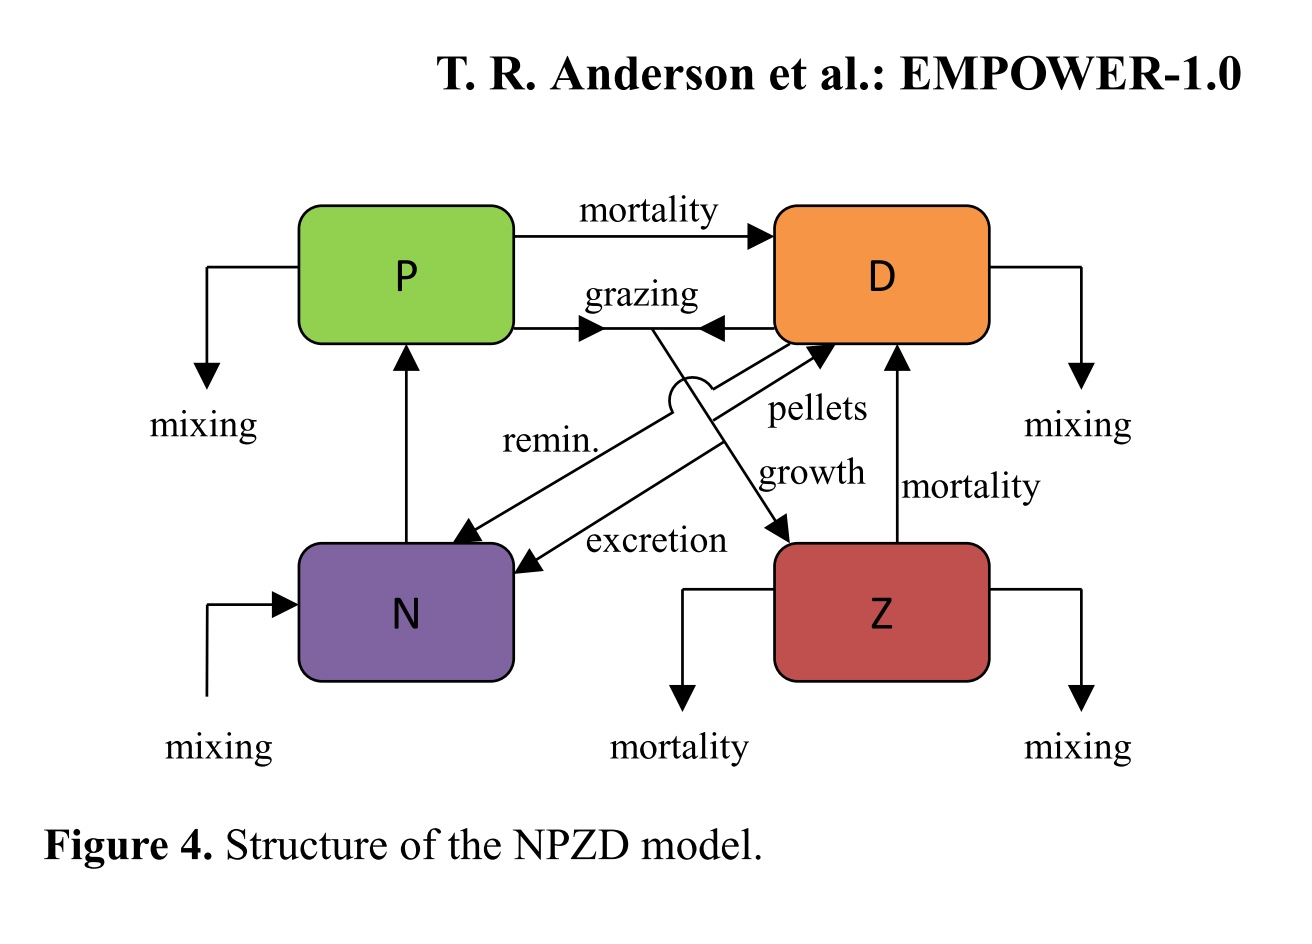

In [1]:
from IPython.display import Image
Image(filename=('empower_model_schematics.jpeg'), width=500)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [5]:
from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.growth_multi_lim import Growth_ML, Eppley_ML, Monod_ML, Smith_ML
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing, ConstantForcing

setting new attr method
read_intrp_forcing


In [6]:
from phydra.components.forcings import EMPOWER_IrradianceFromLat, EMPOWER_ForcingFromFile

from phydra.components.fluxes.EMPOWER_growth import (EMPOWER_Monod_ML, EMPOWER_Smith_ML, 
                                                     EMPOWER_Anderson_Light_ML,
                                                     EMPOWER_Eppley_ML,
                                                     EMPOWER_Growth_ML)

setting new attr method
FNLIcalcA93
setting new attr method
FNaphy
setting new attr method
SmithFunc


In [7]:
EMPOWER_Anderson_Light_ML

phydra.backend.component.EMPOWER_Anderson_Light_ML

# CREATE MODEL

In [8]:
EMPOWER = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SV,
    'Zooplankton':SV,
    'Detritus':SV,
    
    # Mixing:
    'K':Mixing_K,
    'Upwelling':SlabUpwelling_KfromGroup,
    'Mixing':SlabMixing_KfromGroup,
    'Sinking':SlabSinking,

    # Growth
    'Growth':EMPOWER_Growth_ML,
    'Nut_lim':EMPOWER_Monod_ML,
    'Light_lim':EMPOWER_Anderson_Light_ML,
    'Temp_lim':EMPOWER_Eppley_ML,
    
    # Grazing
    'Grazing':HollingTypeIII_ResourcesListInput_Consumption2Group,
    'GGE':GrossGrowthEfficiency,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange,
    'PhytoQuadMortality':QuadraticExchange,
    'ZooLinMortality':LinearExchange,
    'HigherOrderPred':QuadraticDecay,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'Irradiance':EMPOWER_IrradianceFromLat,
    'Forcings':EMPOWER_ForcingFromFile,
                     })

In [23]:
EMPOWER_smith = EMPOWER.update_processes({'Light_lim':EMPOWER_Smith_ML})

In [9]:
print(EMPOWER)

<xsimlab.Model (24 processes, 64 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Forcings
    MLD_label                [in] label / Empower MLD Forcing
    MLDderiv_label           [in] label / Empower MLDderiv Forcing
    SST_label                [in] label / Empower SST Forcing
    N0_label                 [in] label / Empower N0 Forcing
  

# SETUP MODEL

In [10]:
num_years = 5

batch_setup = phydra.setup(solver='odeint', model=EMPOWER,
            time=np.arange(0,365*num_years),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':10.},
                    'Phytoplankton':{'var_label':'P','var_init':.1},
                    'Zooplankton':{'var_label':'Z','var_init':.1},
                    'Detritus':{'var_label':'D','var_init':.1},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Nut_lim':{'resource':'N', 'halfsat':.85},
                    'Light_lim':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'alpha':('batch', [0.15, 0.15, 0.075, 0.075]), 'CtoChl':75.},
                    'Temp_lim':{'temp':'SST', 'VpMax':('batch', [2.5, 2.5, 1.25, 1.25])},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':('batch', [1., 1., 1.25, 2.]), 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.015},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.025},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':('batch', [0.02, 0., 0.02, 0.02])},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.06},

                    # Forcings
                    'Irradiance':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                  'I0_label':'I0'},
                    'Forcings':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                'MLD_label':'MLD', 'SST_label':'SST',
                                'MLDderiv_label':'MLDderiv', 'N0_label':'N0'},
            })

# RUN MODEL

In [12]:
with EMPOWER:
    batch_out = batch_setup.xsimlab.run(batch_dim='batch')
    #tropical_out = tropical_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Forcings
Initializing component Irradiance
Initializing component K
K_mixing
Initializing component ZooLinMortality
Initializing component PhytoQuadMortality
Initializing component DetRemineralisation
Initializing component Sinking
Initializing component PhytoLinMortality
Initializing component Grazing
Grazing_grazing
Initializing component Nut_lim
Nut_lim_monod_lim
Initializing component HigherOrderPred
Initializing component Temp_lim
Temp_lim_temp_dependence
Initializing component Upwelling
Initializing component Mixing
Initializing component GGE
Initializing component Light_lim
Light_lim_irradiance_out
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x1658464c0>
Model is assembled:
Model contains: 
Variables:['time', 'N', 

In [27]:
num_years = 5

batch_setup_2 = phydra.setup(solver='odeint', model=EMPOWER_smith,
            time=np.arange(0,365*num_years),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':10.},
                    'Phytoplankton':{'var_label':'P','var_init':.1},
                    'Zooplankton':{'var_label':'Z','var_init':.1},
                    'Detritus':{'var_label':'D','var_init':.1},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Nut_lim':{'resource':'N', 'halfsat':.85},
                    'Light_lim':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'alpha':('batch', [0.15, 0.15, 0.075, 0.075]), 'CtoChl':75.},
                    'Temp_lim':{'temp':'SST', 'VpMax':('batch', [2.5, 2.5, 1.25, 1.25])},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':('batch', [1., 1., 1.25, 2.]), 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.015},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.025},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':('batch', [0.02, 0., 0.02, 0.02])},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.06},

                    # Forcings
                    'Irradiance':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                  'I0_label':'I0'},
                    'Forcings':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                'MLD_label':'MLD', 'SST_label':'SST',
                                'MLDderiv_label':'MLDderiv', 'N0_label':'N0'},
            })

with EMPOWER_smith:
    batch_out_2 = batch_setup_2.xsimlab.run(batch_dim='batch')

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Forcings
Initializing component Irradiance
Initializing component K
K_mixing
Initializing component ZooLinMortality
Initializing component PhytoQuadMortality
Initializing component DetRemineralisation
Initializing component Sinking
Initializing component PhytoLinMortality
Initializing component Grazing
Grazing_grazing
Initializing component Nut_lim
Nut_lim_monod_lim
Initializing component HigherOrderPred
Initializing component Temp_lim
Temp_lim_temp_dependence
Initializing component Upwelling
Initializing component Mixing
Initializing component GGE
Initializing component Light_lim
Light_lim_smith_light_lim
Initializing component Growth
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x1670f0580>
Model is assembled:
Model contains: 
Variables:['time', 'N',

In [26]:
batch_out

<xarray.Dataset>
Dimensions:                           (batch: 4, clock: 2, input_time: 1825, resources: 2, sinking_vars: 3, sinking_vars_full: 3, time: 1825)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: batch, input_time, resources, sinking_vars, sinking_vars_full, time
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (batch, time) float64 0.005788 ... 0.00...
    DetRemineralisation__rate         float64 0.06
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 0.1
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (batch, time) float64 0.1 ... 0.1033
    Forcings__MLD_label               <U3 'MLD'
    Forcings__MLD_value               (batch, time) float64 193.4 ... 88.71
    Forcings__MLDderiv_label          <U8 'MLDderiv'
    Forcings__MLDderiv_value          (batch, time) float64 3.199 ... -0.8153
    Forcings__N0_label                <U2 'N0'
    Forcings__N0_value                (batch, time) float64 7.364 7.42 ... 26.1
    Forcings__SST_label               <U3 'SST'
    Forcings__SST_value               (batch, time) float64 12.65 ... 3.326
    Forcings__station                 (batch) <U8 'biotrans' ... 'kerfix'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (batch, time) float64 0.001323 ... 0.01577
    GGE__beta                         float64 0.69
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (batch, time) float64 0.0007928 ... 0.0...
    GGE__epsilon                      float64 0.75
    GGE__excreted_nutrient            <U1 'N'
    GGE__excretion_value              (batch, time) float64 0.0004412 ... 0.0...
    Grazing__Imax                     (batch) float64 1.0 1.0 1.25 2.0
    Grazing__consumer                 <U1 'Z'
    Grazing__feed_prefs               (resources) float64 0.67 0.33
    Grazing__grazing_value            (batch, resources, time) float64 0.0017...
    Grazing__kZ                       float64 0.6
    Grazing__resources                (resources) <U1 'P' 'D'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (batch, time) float64 0.004493 ... 0.0321
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (batch, time) float64 0.003214 ... 0.01035
    HigherOrderPred__rate             float64 0.34
    HigherOrderPred__var              <U1 'Z'
    Irradiance__I0_label              <U2 'I0'
    Irradiance__I0_value              (batch, time) float64 410.4 ... 2.549e+03
    Irradiance__station               (batch) <U8 'biotrans' ... 'kerfix'
    K__kappa                          float64 0.13
    K__mixing_value                   (batch, time) float64 0.01708 ... 0.001459
    K__mld                            <U3 'MLD'
    K__mld_deriv                      <U8 'MLDderiv'
    Light_lim__CtoChl                 float64 75.0
    Light_lim__alpha                  (batch) float64 0.15 0.15 0.075 0.075
    Light_lim__i_0                    <U2 'I0'
    Light_lim__irradiance_out_value   (batch, time) float64 0.04893 ... 0.1547
    Light_lim__kc                     float64 0.03
    Light_lim__kw                     float64 0.04
    Light_lim__mld                    <U3 'MLD'
    Light_lim__pigment_biomass        <U1 'P'
    Mixing__mixing_value              (batch, sinking_vars_full, time) float64 ...
    Mixing__vars_sink                 (sinking_vars) <U1 'P' 'Z' 'D'
    Nut_lim__halfsat                  float64 0.85
    Nut_lim__monod_lim_value          (batch, time) float64 0.9215 ... 0.9656
    Nut_lim__resource                 <U1 'N'
    Nutrient__var_init                float64 10.0
    Nutrient__var_label               <U1 'N'
    Nutrient__var_value               (batch, time) float64 10

In [14]:
# batch_out.to_netcdf('test.nc')

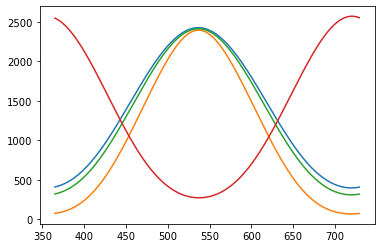

In [15]:
plt.plot(batch_out.Time__time[365:365*2], batch_out.Irradiance__I0_value.T[365:365*2])
plt.show()

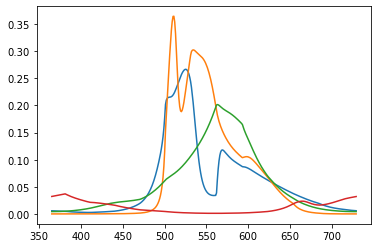

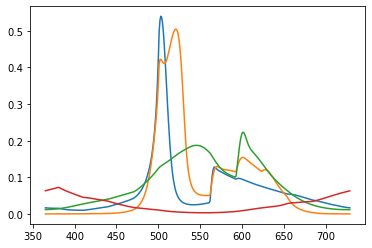

In [28]:
plt.plot(batch_out.Time__time[365:365*2], batch_out.Growth__growth_value.T[365:365*2])
plt.show()

plt.plot(batch_out_2.Time__time[365:365*2], batch_out_2.Growth__growth_value.T[365:365*2])
plt.show()

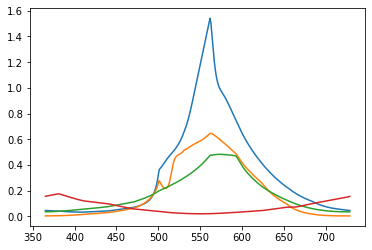

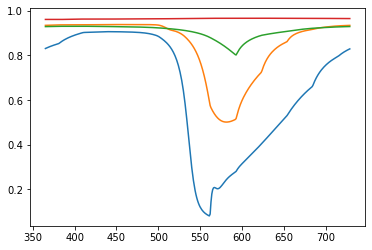

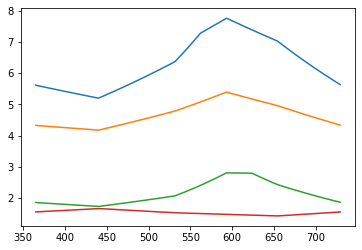

In [17]:
plt.plot(batch_out.Time__time[365:365*2], batch_out.Light_lim__irradiance_out_value.T[365:365*2])
plt.show()

plt.plot(batch_out.Time__time[365:365*2], batch_out.Nut_lim__monod_lim_value.T[365:365*2])
plt.show()

plt.plot(batch_out.Time__time[365:365*2], batch_out.Temp_lim__temp_dependence_value.T[365:365*2])
plt.show()

# Publication Plot

In [30]:
last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

In [1]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 7]

trop_col = 'red'
temp_col = 'blue'

labels = {'model_pico':'darkgreen','model_nano':'green','model_micro':'lightgreen', 'model_nuts':'#955196','model_det':'brown','model_Z':'darkorange','data':'grey'}

culr=[temp_col,trop_col]

culrZ=['seagreen','midnightblue']

culrD=['turquoise','cornflowerblue']

culrNPZD=['#955196','green','darkorange','brown']

NameError: name 'plt' is not defined

In [32]:
from phydra.utility.forcingdata import VerifData

biotrans_loc = {'lat':47,'lon':-20, 'rbb':2}
india_loc = {'lat':60,'lon':-20, 'rbb':2}
papa_loc = {'lat':50,'lon':-147, 'rbb':2}
kerfix_loc = {'lat':-50.4,'lon':68.25, 'rbb':2}

biotrans_verif_data = VerifData(**biotrans_loc)
india_verif_data = VerifData(**india_loc)
papa_verif_data = VerifData(**papa_loc)
kerfix_verif_data = VerifData(**kerfix_loc)

VerifData forcing created


/Users/bpo/Documents/GitHub/phydra/examples/../phydra/utility/forcingdata.py:163: RuntimeWarning: Mean of empty slice
  outforcing = list(np.nanmean(ncdat[:, selectarea], axis=1))


VerifData forcing created
VerifData forcing created
VerifData forcing created


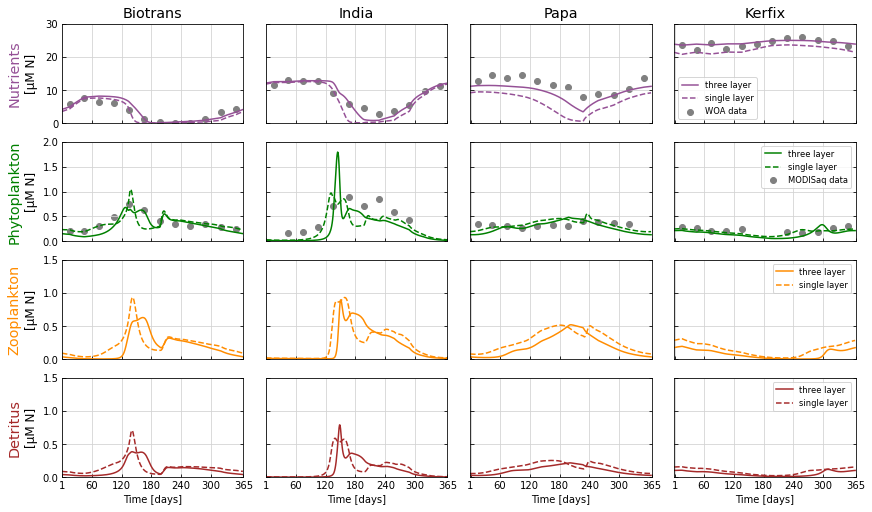

In [48]:
numcols = 4
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        axe[i].grid(True, color='lightgrey')
        #axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
def modeloutputplot(i, dataset, verifdata, secondaryline=False):
    timedays_ly = dataset.Time__time[0:365]
    
    N_Max = 30 #np.max(dataset.Nutrient__var_value[last_year_slice]) + np.max(dataset.Nutrient__var_value[last_year_slice]) * 0.1
    #Pall = outarray_ly[:,1]    
    P_Max = 2. #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    #Zall = outarray_ly[:,2]
    Z_Max = 1.5 #np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 1.5 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)

    if not secondaryline:
        # Figure 1
        # N
        #print(np.max(dataset.Nutrient__var_value))
        if i == 0:  
            ax1[i].annotate('Nutrients',xy=(0, 1),rotation=90,xytext=(-110,N_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[0])
            ax1[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax2[i].annotate('Phytoplankton',xy=(0, 1),rotation=90,xytext=(-110,P_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[1])
            ax2[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax3[i].annotate('Zooplankton',xy=(0, 1),rotation=90,xytext=(-110,Z_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[2])
            ax3[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax4[i].annotate('Detritus',xy=(0, 1),rotation=90,xytext=(-110,D_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[3])
            ax4[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

        ax1[i].set_ylim(0, N_Max)

        ax1[i].scatter(dpm_cumsum, verifdata.N, label='WOA data', c='grey')
        ax1[i].plot(timedays_ly, dataset.Nutrient__var_value[last_year_slice], c=culrNPZD[0], label='three layer')
        
        ChlConv = True
        # Phyto
        CtoChla = 75  # g/g
        MolarMassC = 12.0107
        CtoNratioPhyto = 6.625
        muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

        ax2[i].scatter(dpm_cumsum, np.array(verifdata.chla) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')

        ax2[i].plot(timedays_ly, dataset.Phytoplankton__var_value[last_year_slice], c=culrNPZD[1],  label='three layer')
        ax2[i].set_ylim(0, P_Max)

        # Z
        ax3[i].plot(timedays_ly, dataset.Zooplankton__var_value[last_year_slice], c=culrNPZD[2], label='three layer')

        ax3[i].tick_params('y', labelsize=10)
        ax3[i].set_ylim(0, Z_Max)
        #ax4[i_plot].set_title('Zooplankton')

        # D
        ax4[i].plot(timedays_ly, dataset.Detritus__var_value[last_year_slice], c=culrNPZD[3], label='three layer')
        ax4[i].set_ylim(0,D_Max)
        ax4[i].set_xlabel('Time [days]')
        
        if i > 2:
            ax1[i].legend(fontsize='small')
            ax2[i].legend(fontsize='small')
            ax3[i].legend(fontsize='small')
            ax4[i].legend(fontsize='small')

        if i >= 1:
            ax1[i].set_yticklabels([])
            ax2[i].set_yticklabels([])
            ax3[i].set_yticklabels([])
            ax4[i].set_yticklabels([])
            #ax4[i].set_xlabel('[days]')
            
    else: 
        ax1[i].plot(timedays_ly, dataset.Nutrient__var_value[last_year_slice], 
                    linestyle='--', c=culrNPZD[0], label='single layer')
        
        ax2[i].plot(timedays_ly, dataset.Phytoplankton__var_value[last_year_slice], 
                    linestyle='--', c=culrNPZD[1],  label='single layer')
        
        ax3[i].plot(timedays_ly, dataset.Zooplankton__var_value[last_year_slice], 
                    linestyle='--', c=culrNPZD[2], label='single layer')
        
        ax4[i].plot(timedays_ly, dataset.Detritus__var_value[last_year_slice], 
                    linestyle='--', c=culrNPZD[3], label='single layer')
        
        if i > 2:
            ax1[i].legend(fontsize='small')
            ax2[i].legend(fontsize='small')
            ax3[i].legend(fontsize='small')
            ax4[i].legend(fontsize='small')

    
    
modeloutputplot(0, batch_out.isel(batch=0), biotrans_verif_data)
modeloutputplot(0, batch_out_2.isel(batch=0), biotrans_verif_data, secondaryline=True)

modeloutputplot(1, batch_out.isel(batch=1), india_verif_data)
modeloutputplot(1, batch_out_2.isel(batch=1), biotrans_verif_data, secondaryline=True)

modeloutputplot(2, batch_out.isel(batch=2), papa_verif_data)
modeloutputplot(2, batch_out_2.isel(batch=2), biotrans_verif_data, secondaryline=True)

modeloutputplot(3, batch_out.isel(batch=3), kerfix_verif_data)
modeloutputplot(3, batch_out_2.isel(batch=3), biotrans_verif_data, secondaryline=True)

# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

ax1[0].set_title('Biotrans', size='x-large')
ax1[1].set_title('India', size='x-large')
ax1[2].set_title('Papa', size='x-large')
ax1[3].set_title('Kerfix', size='x-large')


# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('02_EMPOWER_NPZDslab_lightcomp.pdf', bbox_inches='tight')
plt.show()

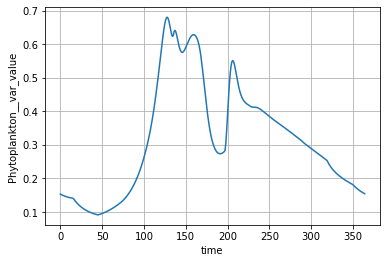

In [25]:
dataset = batch_out.isel(batch=0)

dataset.Phytoplankton__var_value[last_year_slice].plot()
plt.grid()
#plt.savefig('phyto_plot_for_schematic.pdf', bbox_inches='tight')

# TODO: add depth integral of light sensu Anderson!

In [43]:
stations = list(batch_out.Forcings__station.values)

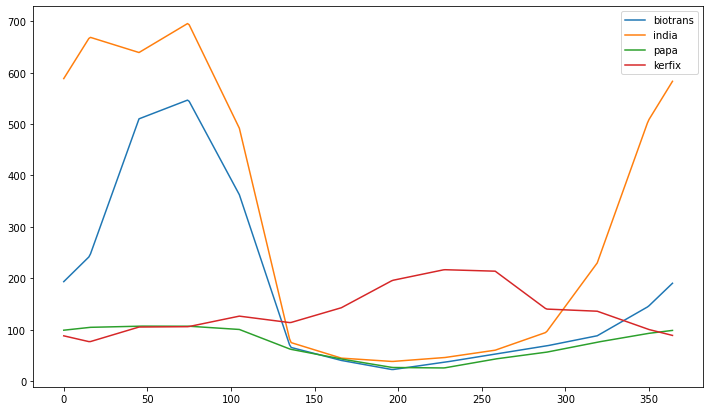

In [49]:
for i, label in zip(range(4), stations):
    plt.plot(batch_out.Forcings__MLD_value.T[:365,i], label=label)
    plt.legend()

<ipython-input-77-4846041e9201>:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(hspace=0.25, wspace=0.4)


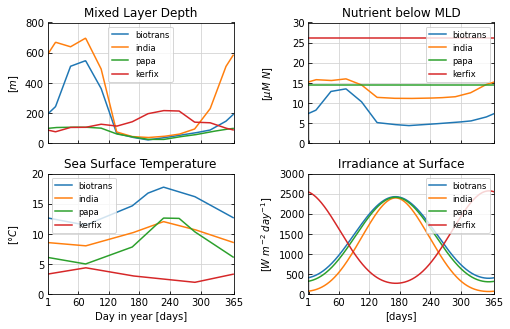

In [77]:
plt.rcParams['figure.figsize'] = [8, 5]

numcols = 2
f1, (ax1, ax2) = plt.subplots(2, numcols, sharex='col', constrained_layout=True)  #, sharey='row')
axes = (ax1, ax2)
plt.setp(axes, xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in axes:
    for i in range(numcols):
        axe[i].grid(True, color='lightgrey')
        #axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
for i, label in zip(range(4), stations):
    ax1[0].plot(batch_out.Forcings__MLD_value.T[:365,i], label=label)
    ax1[0].legend(fontsize='small')
    ax1[0].set_title('Mixed Layer Depth')
    ax1[0].set_ylabel('[$m$]')
    ax1[0].set_ylim(0,800)

for i, label in zip(range(4), stations):
    ax1[1].plot(batch_out.Forcings__N0_value.T[:365,i], label=label)
    ax1[1].legend(fontsize='small')
    ax1[1].set_title('Nutrient below MLD')
    ax1[1].set_ylabel('[$µM$ $N$]')
    ax1[1].set_ylim(0,30)
    
for i, label in zip(range(4), stations):
    ax2[0].plot(batch_out.Forcings__SST_value.T[:365,i], label=label)
    ax2[0].legend(fontsize='small')
    ax2[0].set_title('Sea Surface Temperature')
    ax2[0].set_ylim(0,20)
    ax2[0].set_ylabel('$[°C]$')
    ax2[0].set_xlabel('Day in year [days]')
    
for i, label in zip(range(4), stations):
    ax2[1].plot(batch_out.Irradiance__I0_value.T[:365,i], label=label)
    ax2[1].legend(fontsize='small')
    ax2[1].set_title('Irradiance at Surface')
    ax2[1].set_ylim(0,3000)
    ax2[1].set_ylabel('[$W$ $m^{-2}$ $day^{-1}$]')
    ax2[1].set_xlabel('[days]')

# Setting the values for all axes.
plt.setp(axes, xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

plt.subplots_adjust(hspace=0.25, wspace=0.4)

plt.savefig('02_EMPOWER_NPZDslab_forcing.pdf', bbox_inches='tight')
plt.show()

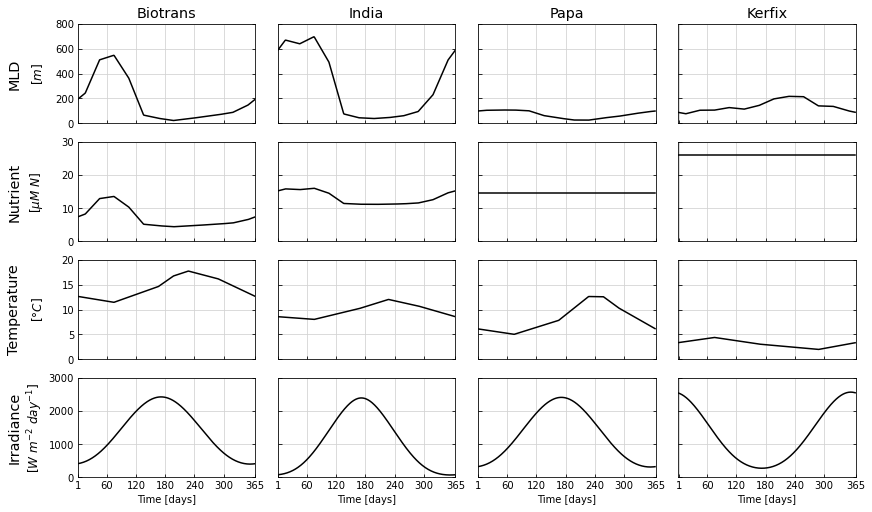

In [66]:
numcols = 4
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        axe[i].grid(True, color='lightgrey')
        #axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
def modeloutputplot(i, dataset, verifdata, secondaryline=False):
    timedays_ly = dataset.Time__time[0:365]
    
    color = "black"
    
    N_Max = 800 #np.max(dataset.Nutrient__var_value[last_year_slice]) + np.max(dataset.Nutrient__var_value[last_year_slice]) * 0.1
    #Pall = outarray_ly[:,1]    
    P_Max = 30 #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    #Zall = outarray_ly[:,2]
    Z_Max = 20 #np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 3000 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)

    # Figure 1
    # N
    #print(np.max(dataset.Nutrient__var_value))
    if i == 0:  
        ax1[i].annotate('MLD',xy=(0, 1),rotation=90,xytext=(-145,N_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[0])
        ax1[i].set_ylabel('[$m$]', multialignment='center', fontsize=12)

        ax2[i].annotate('Nutrient',xy=(0, 1),rotation=90,xytext=(-145,P_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[1])
        ax2[i].set_ylabel('[$µM$ $N$]', multialignment='center', fontsize=12)

        ax3[i].annotate('Temperature',xy=(0, 1),rotation=90,xytext=(-145,Z_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[2])
        ax3[i].set_ylabel('$[°C]$', multialignment='center', fontsize=12)

        ax4[i].annotate('Irradiance',xy=(0, 1),rotation=90,xytext=(-145,D_Max/2), 
                        size='x-large', 
                        verticalalignment='center')#, c=culrNPZD[3])
        ax4[i].set_ylabel('[$W$ $m^{-2}$ $day^{-1}$]', multialignment='center', fontsize=12)

    ax1[i].set_ylim(0, N_Max)

    ax1[i].plot(timedays_ly, dataset.Forcings__MLD_value[last_year_slice], c=color, label='three layer')


    ax2[i].plot(timedays_ly, dataset.Forcings__N0_value[last_year_slice], c=color,  label='three layer')
    ax2[i].set_ylim(0, P_Max)

    # Z
    ax3[i].plot(timedays_ly, dataset.Forcings__SST_value[last_year_slice], c=color, label='three layer')

    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    # D
    ax4[i].plot(timedays_ly, dataset.Irradiance__I0_value[last_year_slice], c=color, label='three layer')
    ax4[i].set_ylim(0,D_Max)
    ax4[i].set_xlabel('Time [days]')

    if False:
        ax1[i].legend(fontsize='small')
        ax2[i].legend(fontsize='small')
        ax3[i].legend(fontsize='small')
        ax4[i].legend(fontsize='small')

    if i >= 1:
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
        ax4[i].set_yticklabels([])
        #ax4[i].set_xlabel('[days]')
            

    
    
modeloutputplot(0, batch_out.isel(batch=0), biotrans_verif_data)
#modeloutputplot(0, batch_out_2.isel(batch=0), biotrans_verif_data, secondaryline=True)

modeloutputplot(1, batch_out.isel(batch=1), india_verif_data)
#modeloutputplot(1, batch_out_2.isel(batch=1), biotrans_verif_data, secondaryline=True)

modeloutputplot(2, batch_out.isel(batch=2), papa_verif_data)
#modeloutputplot(2, batch_out_2.isel(batch=2), biotrans_verif_data, secondaryline=True)

modeloutputplot(3, batch_out.isel(batch=3), kerfix_verif_data)
#modeloutputplot(3, batch_out_2.isel(batch=3), biotrans_verif_data, secondaryline=True)

# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

ax1[0].set_title('Biotrans', size='x-large')
ax1[1].set_title('India', size='x-large')
ax1[2].set_title('Papa', size='x-large')
ax1[3].set_title('Kerfix', size='x-large')


# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.savefig('02_EMPOWER_NPZD_FORCING.pdf', bbox_inches='tight')
plt.show()

In [397]:
# old code:

In [362]:
all_fluxes = pandas.read_csv("out_fluxes.txt", sep=r'\s*,\s*',
                           header=None, encoding='ascii', engine='python')

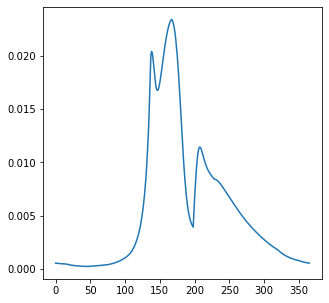

In [363]:
plt.plot(all_fluxes[1])

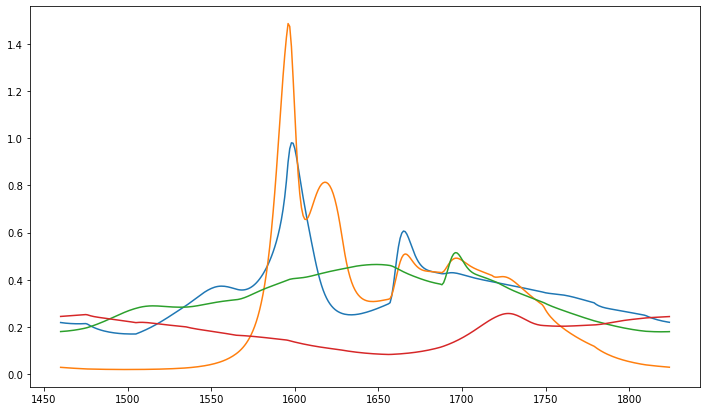

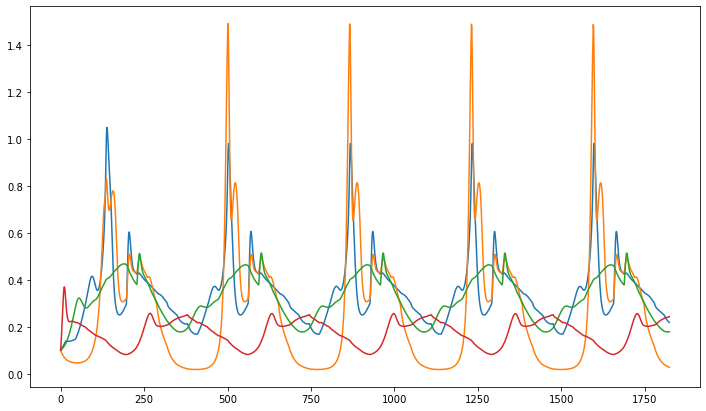

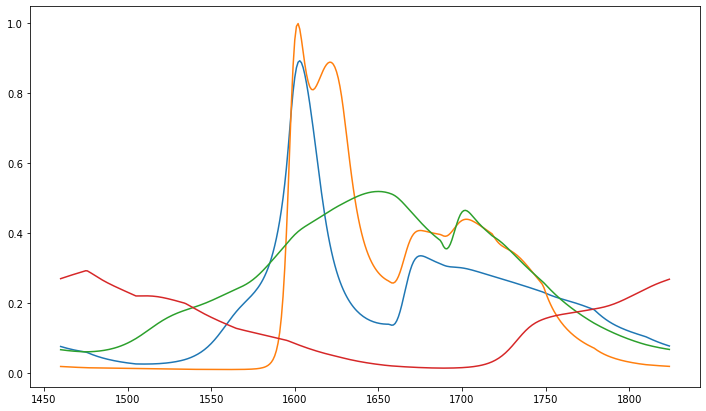

In [356]:
plt.plot(time[last_year_slice], batch_out.Phytoplankton__var_value.T[last_year_slice])
plt.show()

plt.plot(time, batch_out.Phytoplankton__var_value.T)
plt.show()

plt.plot(time[last_year_slice], batch_out.Zooplankton__var_value.T[last_year_slice])
plt.show()


In [357]:
batch_out.Forcings__station

<xarray.DataArray 'Forcings__station' (batch: 4)>
array(['biotrans', 'india', 'papa', 'kerfix'], dtype='<U8')
Dimensions without coordinates: batch
Attributes:
    description:  name of station, options: 'india', 'biotrans', 'kerfix', 'p...

In [358]:
plt.rcParams['figure.figsize'] = [5, 5]

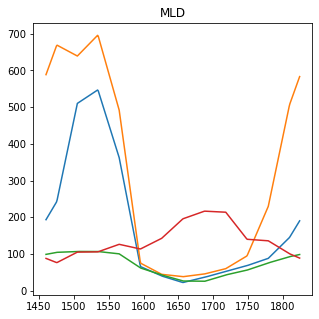

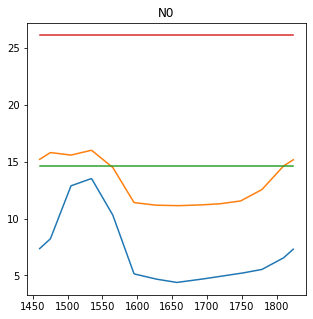

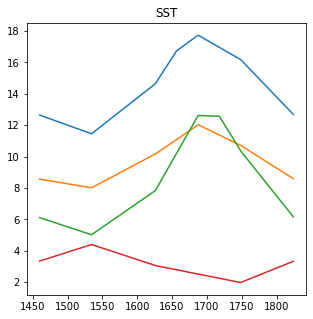

In [359]:
plt.plot(time[last_year_slice], batch_out.Forcings__MLD_value.T[last_year_slice])
plt.title('MLD')
plt.show()

plt.plot(time[last_year_slice], batch_out.Forcings__N0_value.T[last_year_slice])
plt.title('N0')
plt.show()

plt.plot(time[last_year_slice], batch_out.Forcings__SST_value.T[last_year_slice])
plt.title('SST')
plt.show()

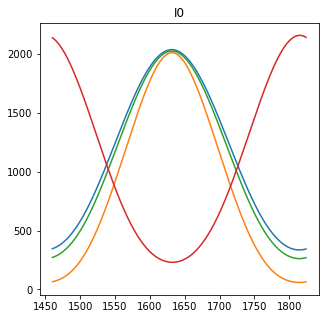

In [360]:
plt.plot(time[last_year_slice], batch_out.Irradiance__I0_value.T[last_year_slice])
plt.title('I0')
plt.show()

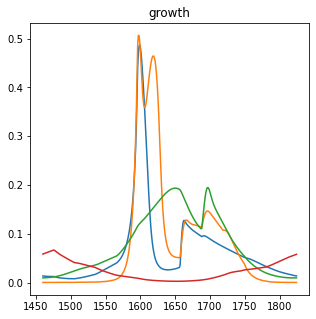

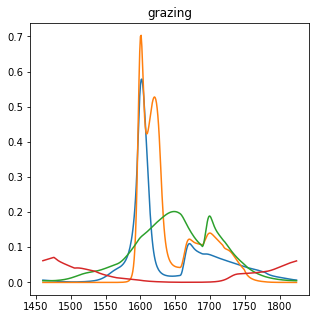

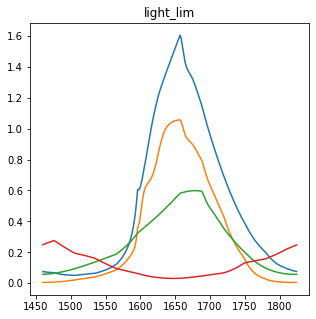

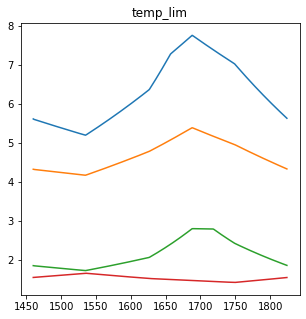

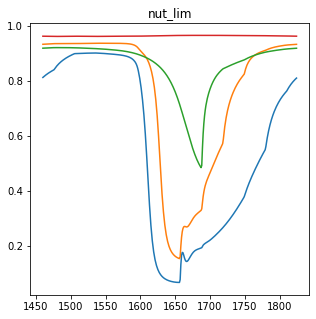

In [361]:
plt.plot(time[last_year_slice], batch_out.Growth__growth_value.T[last_year_slice])
plt.title('growth')
plt.show()
plt.plot(time[last_year_slice], np.sum(batch_out.Grazing__grazing_value.T[last_year_slice], axis=1))
plt.title('grazing')
plt.show()
plt.plot(time[last_year_slice], batch_out.Light_lim__smith_light_lim_value.T[last_year_slice])
plt.title('light_lim')
plt.show()
plt.plot(time[last_year_slice], batch_out.Temp_lim__temp_dependence_value.T[last_year_slice])
plt.title('temp_lim')
plt.show()
plt.plot(time[last_year_slice], batch_out.Nut_lim__monod_lim_value.T[last_year_slice])
plt.title('nut_lim')
plt.show()

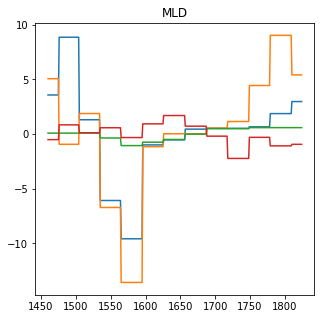

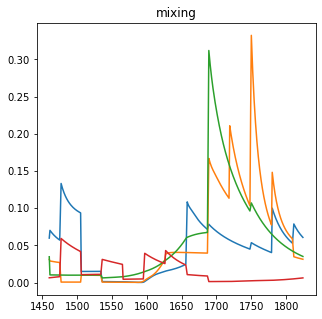

In [330]:
plt.plot(time[last_year_slice], batch_out.Forcings__MLDderiv_value.T[last_year_slice])
plt.title('MLD')
plt.show()

plt.plot(time[last_year_slice], batch_out.Upwelling__mixing_value.T[last_year_slice])
plt.title('mixing')
plt.show()

In [131]:
batch_out.isel(batch=0)

<xarray.Dataset>
Dimensions:                           (clock: 2, input_time: 1825, resources: 2, sinking_vars: 3, sinking_vars_full: 3, time: 1825)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: input_time, resources, sinking_vars, sinking_vars_full, time
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.005782 ... 0.006491
    DetRemineralisation__rate         float64 0.06
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 0.1
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (time) float64 0.1 0.09292 ... 0.1078
    Forcings__MLD_label               <U3 'MLD'
    Forcings__MLD_value               (time) float64 191.3 194.9 ... 185.4 188.4
    Forcings__MLDderiv_label          <U8 'MLDderiv'
    Forcings__MLDderiv_value          (time) float64 3.575 3.575 ... 2.972 2.972
    Forcings__N0_label                <U2 'N0'
    Forcings__N0_value                (time) float64 7.329 7.392 ... 7.226 7.278
    Forcings__SST_label               <U3 'SST'
    Forcings__SST_value               (time) float64 12.65 12.63 ... 12.74 12.69
    Forcings__station                 <U8 'biotrans'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (time) float64 0.001372 ... 0.007351
    GGE__beta                         float64 0.69
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (time) float64 0.0008221 ... 0.004403
    GGE__epsilon                      float64 0.75
    GGE__excreted_nutrient            <U1 'N'
    GGE__excretion_value              (time) float64 0.0004574 ... 0.00245
    Grazing__Imax                     float64 1.0
    Grazing__consumer                 <U1 'Z'
    Grazing__feed_prefs               (resources) float64 0.67 0.33
    Grazing__grazing_label            <U15 'Grazing_grazing'
    Grazing__grazing_value            (resources, time) float64 0.001847 ... ...
    Grazing__kZ                       float64 0.6
    Grazing__resources                (resources) <U1 'P' 'D'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (time) float64 0.01061 0.01061 ... 0.02194
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (time) float64 0.003209 ... 0.004638
    HigherOrderPred__rate             float64 0.34
    HigherOrderPred__var              <U1 'Z'
    Irradiance__I0_label              <U2 'I0'
    Irradiance__I0_value              (time) float64 345.2 347.2 ... 341.9 343.6
    Irradiance__station               <U8 'biotrans'
    K__kappa                          float64 0.13
    K__mixing_label                   <U8 'K_mixing'
    K__mixing_value                   (time) float64 0.01918 0.01918 ... 0.0166
    K__mld                            <U3 'MLD'
    K__mld_deriv                      <U8 'MLDderiv'
    Light_lim__CtoChl                 float64 75.0
    Light_lim__alpha                  float64 0.15
    Light_lim__i_0                    <U2 'I0'
    Light_lim__kc                     float64 0.03
    Light_lim__kw                     float64 0.04
    Light_lim__mld                    <U3 'MLD'
    Light_lim__pigment_biomass        <U1 'P'
    Light_lim__smith_light_lim_label  <U25 'Light_lim_smith_light_lim'
    Light_lim__smith_light_lim_value  (time) float64 0.1123 0.1123 ... 0.104
    Mixing__mixing_value              (sinking_vars_full, time) float64 0.001...
    Mixing__vars_sink                 (sinking_vars) <U1 'P' 'Z' 'D'
    Nut_lim__halfsat                  float64 0.85
    Nut_lim__monod_lim_label          <U17 'Nut_lim_monod_lim'
    Nut_lim__monod_lim_value          (time) float64 0.9215 0.9215 ... 0.8057
    Nut_lim__resource                 <U1 'N'
    Nutrient__var_init           

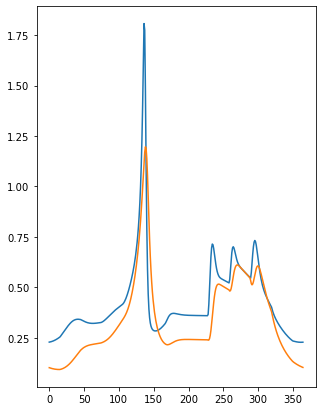

In [62]:
plt.plot(temperate_out.Phytoplankton__var_value[last_year_slice])
plt.plot(temperate_out.Zooplankton__var_value[last_year_slice])

In [300]:
plt.plot(tropical_out.Phytoplankton__var_value[last_year_slice])
plt.plot(tropical_out.Zooplankton__var_value[last_year_slice])

NameError: name 'tropical_out' is not defined

In [36]:
from phydra.utility.forcingdata import VerifData

temperate_verif_data = VerifData(**temperate_forcing_location)
tropical_verif_data = VerifData(**tropical_forcing_location)

VerifData forcing created
VerifData forcing created


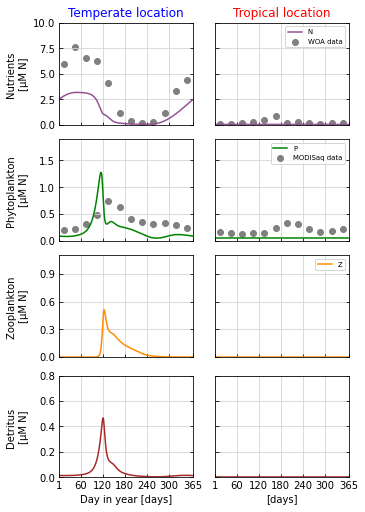

In [38]:
numcols = 2
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        

# color vectors
#colors = ['#edc951', '#dddddd', '#00a0b0', '#343436', '#cc2a36']
colors = ['#808080','#d55e00', '#cc79a7', '#0072b2', '#009e73', 'grey']

lws = [2, 2.5, 4, 5.5]

def modeloutputplot(i, dataset, verifdata):
    timedays_ly = dataset.Time__time[0:365]
    
    N_Max = np.max(dataset.N0__forcing_value[last_year_slice]) + np.max(dataset.N0__forcing_value[last_year_slice]) * 0.1
    #Pall = outarray_ly[:,1]    
    P_Max = 1.9 #np.max(ms.physics.forcing.verif.chla) + 0.9 * np.max(Pall)
    #Zall = outarray_ly[:,2]
    Z_Max = 1.1 #np.max(Zall) + 0.1 * np.max(Zall)
    D_Max = 0.8 #np.max(outarray_ly[:, 3]) + 0.2 * np.max(outarray_ly[:, 3])
    
    if i == 0:
        ax1[i].set_title('Temperate location', color='blue')
    else:
        ax1[i].set_title('Tropical location', color='red')
        

    #print(outarrayx)

    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    #print(timedays_ly)


    # Figure 1
    # N
    ax1[i].scatter(dpm_cumsum, verifdata.N, label='WOA data', c='grey')
    ax1[i].plot(timedays_ly, dataset.Nutrient__var_value[last_year_slice], c=culrNPZD[0], label='N')
    if i == 0:
        ax1[i].set_ylabel('Nutrients \n' '[µM N]', multialignment='center', fontsize=10)
    
    ax1[i].set_ylim(0, 10)
    
    if i == 1:
        ax1[i].legend(fontsize='x-small')


    ChlConv = True
    # Phyto
    CtoChla = 75  # g/g
    MolarMassC = 12.0107
    CtoNratioPhyto = 6.625
    muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

    ax2[i].scatter(dpm_cumsum, np.array(verifdata.chla) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')



    ax2[i].plot(timedays_ly, dataset.Phytoplankton__var_value[last_year_slice], c=culrNPZD[1],  label='P')
    if i == 1:
        ax2[i].legend(fontsize='x-small')
        
    if i == 0:
        ax2[i].set_ylabel('Phytoplankton \n' '[µM N]', multialignment='center', fontsize=10)
    ax2[i].set_ylim(0, P_Max)
    #ax2[1].set_ylim(0, 1)
    # Z

    ax3[i].plot(timedays_ly, dataset.Zooplankton__var_value[last_year_slice], c=culrNPZD[2], label='Z')
    if i == 0:
        ax3[i].set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=10)
        ax4[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=10)
    ax3[i].tick_params('y', labelsize=10)
    ax3[i].set_ylim(0, Z_Max)
    #ax4[i_plot].set_title('Zooplankton')

    
    # D
    ax4[i].plot(timedays_ly, dataset.Detritus__var_value[last_year_slice], c=culrNPZD[3], label='D')
    #ax3[i].set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)
    ax4[i].set_ylim(0,D_Max)
    #ax3[1].set_ylim(0,0.1)
    ax4[0].set_xlabel('Day in year [days]')
    ax4[1].set_xlabel('[days]')
    if i == 1:
        ax3[i].legend(fontsize='x-small')
        ax1[i].set_yticklabels([])
        ax2[i].set_yticklabels([])
        ax3[i].set_yticklabels([])
        ax4[i].set_yticklabels([])
    # Legend

    
    
modeloutputplot(0, temperate_out, temperate_verif_data)
modeloutputplot(1, tropical_out, tropical_verif_data)
# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

#plt.savefig('../02_NPZDslab.pdf', bbox_inches='tight')
plt.show()

# analytics

In [11]:
last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

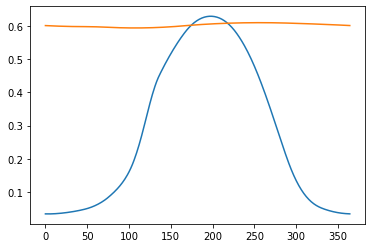

In [12]:
plt.plot(temperate_out.Light_lim__smith_light_lim_value[last_year_slice])
plt.plot(tropical_out.Light_lim__smith_light_lim_value[last_year_slice])

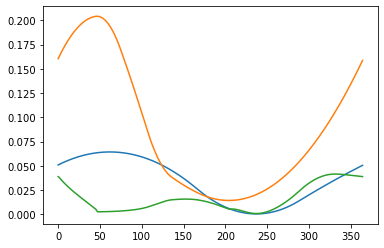

In [13]:
plt.plot(temperate_out.N0__forcing_value[last_year_slice]/100)

plt.plot(temperate_out.MLD__forcing_value[last_year_slice]/1000)

plt.plot(temperate_out.Upwelling__mixing_value[last_year_slice])

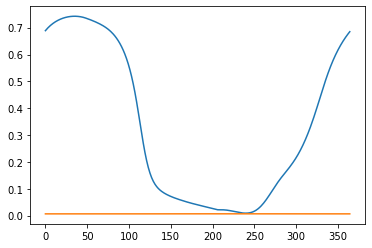

In [14]:
plt.plot(temperate_out.Nut_lim__monod_lim_value[last_year_slice])
plt.plot(tropical_out.Nut_lim__monod_lim_value[last_year_slice])

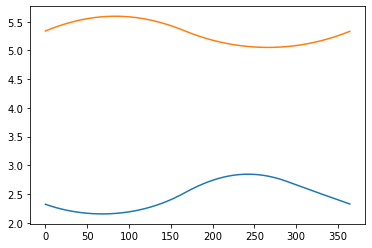

In [15]:
plt.plot(temperate_out.Temp_lim__eppley_growth_value[last_year_slice])
plt.plot(tropical_out.Temp_lim__eppley_growth_value[last_year_slice])

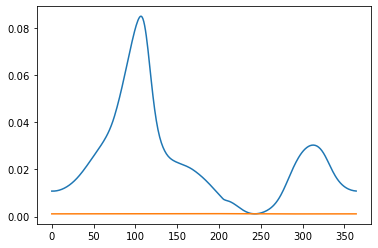

In [16]:
plt.plot(temperate_out.Growth__growth_value[last_year_slice])
plt.plot(tropical_out.Growth__growth_value[last_year_slice])

# TEMPERATE FORCING

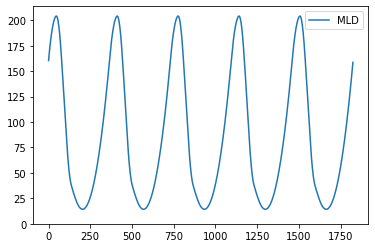

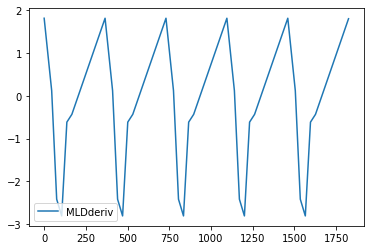

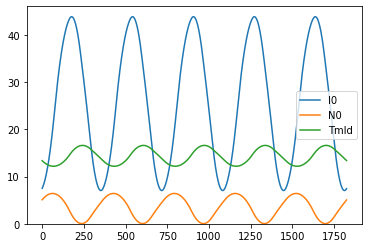

In [11]:
time = temperate_out.Time__time

plt.plot(time, temperate_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, temperate_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, temperate_out.I0__forcing_value, label='I0')
plt.plot(time, temperate_out.N0__forcing_value, label='N0')
plt.plot(time, temperate_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

In [193]:
def FNLIcalcA93(zdepth,Iin,Iout,kPARlay,alpha,Vp,daylnow,ahashnow):
    """
    # Photosynthesis calculated using polynomial approximation (Anderson, 1993)
    """

    omeg = [1.9004,-2.8333E-01,2.8050E-02,-1.4729E-03,3.0841E-05]        # polynomial coefficients for calculating photosynthesis (Platt et al., 1990)

    # Calculate alphamax
    alphamax = alpha*2.602     # alphamax is alpha at wavelength of maximum absorption cross section

    # Calculate daily photosynthesis in each layer, mg C m-2 d-1
    V0 = daylnow*Vp/(np.pi*kPARlay)
    V1 = alphamax*ahashnow*Iin/Vp
    V2 = alphamax*ahashnow*Iout/Vp
    Qpsnow = V0*(omeg[0]*(V1-V2)+omeg[1]*(V1**2-V2**2)+omeg[2]*(V1**3-V2**3)+omeg[3]*(V1**4-V2**4)+omeg[4]*(V1**5-V2**5))

    # convert to dimensionless units to get 0 <= J <= 1
    Lim_I = Qpsnow/zdepth/24.0/Vp

    return Lim_I

In [194]:
alpha = 0.015
VpT = 2.5
daylnow = 12

def Irradiance_over_depth(P, CtoChl, I0, MLD):
    chl = P*6.625*12.0/CtoChl     # chlorophyll, mg m-3 (Redfield ratio of 6.625 mol C mol N-1 assumed for C:N of phytoplankton)
    ss = chl**0.5                # square root of chlorophyll

    kPAR_1 = 0.13096 + 0.030969*ss + 0.042644*ss**2 - 0.013738*ss**3 + 0.0024617*ss**4 - 0.00018059*ss**5 
    kPAR_2 = 0.041025 + 0.036211*ss + 0.062297*ss**2 - 0.030098*ss**3 + 0.0062597*ss**4 - 0.00051944*ss**5
    kPAR_3 = 0.021517 + 0.050150*ss + 0.058900*ss**2 - 0.040539*ss**3 + 0.0087586*ss**4 - 0.00049476*ss**5
    
    kPAR = [kPAR_1, kPAR_2, kPAR_3]

    if MLD <= 5.0:
        jnlay = 1
        zbase = [0., MLD]
        zdep = [0., MLD]
        I_1 = I0 * np.exp(-kPAR_1 * MLD)
        Ibase = [I0, I_1]
    elif MLD > 5.0 and MLD <= 23.0:
        jnlay = 2
        zbase = [0., 5.0, MLD]
        zdep = [0., 5.0, MLD-5.0]
        MLD_rest = MLD - 5.0
        I_1 = I0 * np.exp(-kPAR_1 * 5.0)
        I_2 = I_1 * np.exp(-kPAR_2 * MLD - 5.0)
        Ibase = [I0, I_1, I_2]
    elif MLD > 23.0:
        jnlay = 3
        zbase = [0., 5.0, 23.0, MLD]
        zdep = [0., 5.0, 23.0-5.0, MLD-23.0]
        I_1 = I0 * np.exp(-kPAR_1 * 5.0)
        I_2 = I_1 * np.exp(-kPAR_2 * 23.0 - 5.0)
        I_3 = I_2 * np.exp(-kPAR_3 * MLD - 23.0)
        Ibase = [I0, I_1, I_2, I_3]
    
    aphybase = [0,0,0]
    aphybase[0] = 0.36796 + 0.17537*ss - 0.065276*ss**2 + 0.013528*ss**3 - 0.0011108*ss**4 # a (chl absorption) at ocean surface as function chl
    
    L_Isum = 0
    
    for ilay in range(1,jnlay+1):
        ahash = FNaphy(ss,zbase[ilay-1],zbase[ilay],aphybase[ilay-1]) # change in a with depth
        aphybase[ilay-1] = aphybase[ilay-1]+ahash                       # a at base of layer
        aphyav = aphybase[ilay-1]+ahash*0.5                           # average a in layer (from which alpha is calculated: alpha = a*alphamax
    
        L_I = FNLIcalcA93(zdep[ilay],Ibase[ilay-1],Ibase[ilay],kPAR[ilay-1],alpha,VpT,daylnow,aphyav)
        L_Isum = L_Isum + L_I*zdep[ilay]      # multiply by layer depth in order to set up weighted average for total mixed layer 
    
    L_I = L_Isum/MLD
    
    return L_I

In [195]:
Irradiance_over_depth(0.1, 75, 2000, 25.)

0.5975050420976613

In [65]:
def test_beer(P, i_0, mld, CtoChl):
    kw = 0.03
    kc = 0.04
    
    kPAR = kw + kc * P
    
    I_full = i_0 * np.exp(- kPAR * mld)
    
    # ADD Smith light lim func
    
    return (I_full * mld + i_0) / mld

In [171]:
Irradiance_over_depth(1, 75, 5000, 150)

1
2
3


20.63849606633708

In [67]:
test_beer(1, 80, 150, 75)

0.5355362492813132

In [70]:
#6.625*12.0/75

# TROPICAL FORCING

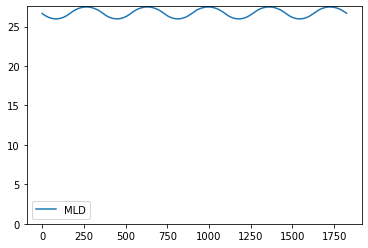

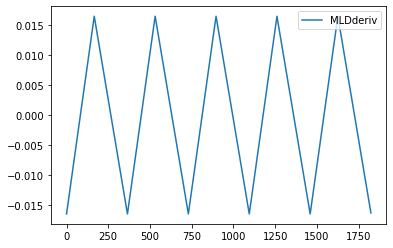

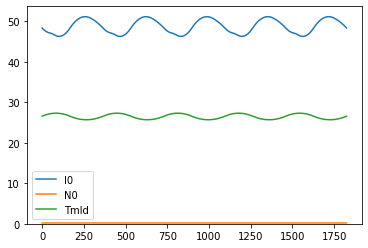

In [12]:
time = tropical_out.Time__time

plt.plot(time, tropical_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, tropical_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, tropical_out.I0__forcing_value, label='I0')
plt.plot(time, tropical_out.N0__forcing_value, label='N0')
plt.plot(time, tropical_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()